In [1]:
import simpy
import collections
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.axes3d import Axes3D

from package import demand, pricing, inventory, hurricane
%matplotlib inline

### Experiment Goals
1. pricing strategy: constant price / linear price
2. the effect of hurricane, we assume all hurricane will make a 5 days orange price strike
3. refill strategy: refill our inventory when the inventory volume is only 30%, 15%, or 8%

### basic settings
1. orange price is the `Orange Juice Futures Historical Data.csv`, and we divide the original price by 2
2. we always refill 50 unit of orange
3. our inventory always start with 50 units of orange

In [2]:
MAX_FRESHNESS = 100
MAX_PRICE = 130
MAX_INVENTORY = 200
CONSTANT_PRICE = 125
LINEAR_PRICE_BETA = -0.05
REFILL_UNIT = 50
STARTING_UNIT = 50

demand_attr = (-0.2, 100, 200)
arrival_attr = (30, 2, 60) #(-5, 2, 10)
total_day = 365
seed = 0

### Orange Price with Hurricane Effect

In [3]:
data = pd.read_csv('Orange Juice Futures Historical Data.csv')
data.index = pd.to_datetime(data['Date'], format='%b %d, %Y')
data = data.sort_index()
orange_price = data['Price'].resample('1D').ffill().div(2).round(2)
print(orange_price.head())

orange_price = orange_price.reset_index(drop=True)

Date
2019-01-01    61.20
2019-01-02    61.20
2019-01-03    60.82
2019-01-04    60.65
2019-01-05    60.65
Freq: D, Name: Price, dtype: float64


In [4]:
hurr = hurricane.Hurricane(seed=seed)
hurr_tuple = hurr.get_all_arrival()
price_change = collections.defaultdict(int)
for time, strike in hurr_tuple:
    time = int(time)
    for i in range(5):
        time += 1
        price_change[time] = strike
price_change = pd.DataFrame.from_dict(price_change, orient='index', columns=['Strike'])
orange_price = pd.concat([orange_price, price_change], axis=1).fillna(0)
orange_price['Final Price'] = orange_price['Price'] * (1 + orange_price['Strike'])

Text(0.5, 0, 'day')

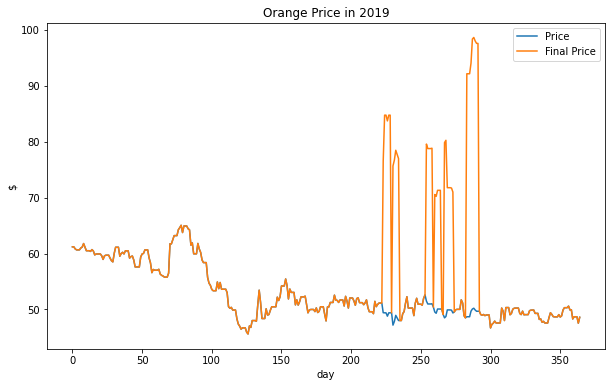

In [5]:
orange_price[['Price', 'Final Price']].plot(figsize=(10, 6))
plt.title('Orange Price in 2019')
plt.ylabel('$')
plt.xlabel('day')

In [6]:
def arrival(env, params, result):
    customers = demand.Customers(params['seed'], params['demand_attr'], params['arrival_attr'])
    arrival_time = customers.get_arrival()

    for a in arrival_time:
        yield env.timeout(a)
        price_kwargs = {
            'current_inventory': params['inventory_class'].get_current_volume(), 
            'constant_price': params['constant_price'], 
            'a': params['linear_price_beta']
        }
        
        if params['strategy'] == 'linear':
            current_price = params['price_strategy'].linear_price(**price_kwargs)
        else:
            current_price = params['price_strategy'].constant_price(**price_kwargs)
        
        current_freshness = params['inventory_class'].get_freshness(int(env.now))
        current_demand = customers.get_demand(current_price, current_freshness)
        current_inventory_level = params['inventory_class'].get_current_volume()

        # storing results
        result['profitList'].append(
            min(current_demand, current_inventory_level) * current_price
        )
        result['freshList'].append(current_freshness)
        result['demandList'].append(current_demand)
        result['inventoryVolumeList'].append(current_inventory_level)
        result['fulfillList'].append(current_demand < current_inventory_level)
        
        
        params['inventory_class'].selling(current_demand)
        


def refill(env, params, result):
    params['inventory_class'].refill(0, params['starting_units'])
    result['refillTimeList'].append(0)
    result['costList'].append(params['orange_price'].loc[0] * params['starting_units'])
    
    
    while True:
        yield env.timeout(1)
        if params['inventory_class'].get_current_volume() <= params['inventory_class'].size * params['refill_percentage']:
            params['inventory_class'].refill(env.now, params['refill_units'])
            result['costList'].append(params['orange_price'].loc[int(env.now)] * params['refill_units'])
            result['refillTimeList'].append(env.now)

In [7]:
def system(strategy='linear', seed=None, refill_percentage=0.08):
    
    global MAX_FRESHNESS
    global MAX_PRICE
    global MAX_INVENTORY
    global CONSTANT_PRICE
    global LINEAR_PRICE_BETA
    global REFILL_UNIT
    global STARTING_UNIT
    global demand_attr
    global arrival_attr
    global total_day
    
    inventory_class = inventory.Inventory(size=MAX_INVENTORY)
    price_strategy = pricing.Price(MAX_PRICE)
    arrival_params = {
        'strategy': strategy,
        'price_strategy': price_strategy,
        'inventory_class': inventory_class,
        'demand_attr': demand_attr,
        'arrival_attr': arrival_attr,
        'linear_price_beta': LINEAR_PRICE_BETA,
        'constant_price': CONSTANT_PRICE,
        'seed': seed
    }
    refill_params = {
        'inventory_class': inventory_class, 
        'refill_percentage': refill_percentage, 
        'orange_price': orange_price['Final Price'], 
        'refill_units': REFILL_UNIT, 
        'starting_units': STARTING_UNIT
    }


    result = collections.defaultdict(list)
    
    env = simpy.Environment()
    env.process(arrival(env, arrival_params, result))
    env.process(refill(env, refill_params, result))
    env.process(inventory_class.inventory_process(env))
    env.run(until=total_day)
    
    return result

In [8]:
def getAverageResult(*result_dict):
    
    avgProfit = 0
    avgCost = 0
    avgCustomerZeroDemand = 0
    avgZeroInventoryLevel = 0
    avgRefillTimes = 0
    avgNotFulfillRatio = 0
    avgFreshness = 0
    count = len(result_dict)
    
    for r in result_dict:
        
        avgProfit += sum(r['profitList'])
        avgCost += sum(r['costList'])
        avgCustomerZeroDemand += sum(np.array(r['demandList']) == 0) / len(r['demandList'])
        avgZeroInventoryLevel += sum(np.array(r['inventoryVolumeList'] == 0) / len(r['inventoryVolumeList']))
        avgRefillTimes += len(r['refillTimeList'])
        avgNotFulfillRatio += sum(~np.array(r['fulfillList'])) / len(r['fulfillList'])
        avgFreshness += sum(r['freshList'])
        
    return {
        'avgProfit': avgProfit, 
        'avgCost': avgCost, 
        'avgCustomerZeroDemand': avgCustomerZeroDemand, 
        'avgZeroInventoryLevel': avgZeroInventoryLevel, 
        'avgRefillTimes': avgRefillTimes, 
        'avgNotFulfillRatio': avgNotFulfillRatio, 
        'avgFreshness': avgFreshness
    }